# Read in the data

In [1]:
import pandas as pd
import numpy
import re

data_files = [
    "ap_2010.csv",
    "class_size.csv",
    "demographics.csv",
    "graduation.csv",
    "hs_directory.csv",
    "sat_results.csv"
]
data = {}

for f in data_files:
    key_name = f.replace(".csv", "")
    d = pd.read_csv(f"schools/{f}")
    data[key_name] = d

# Read in the surveys

In [2]:
all_survey = pd.read_csv("schools/survey_all.txt", delimiter="\t", encoding='windows-1252')
d75_survey = pd.read_csv("schools/survey_d75.txt", delimiter="\t", encoding='windows-1252')
survey = pd.concat([all_survey, d75_survey], axis=0)

survey = survey.copy()
survey["DBN"] = survey["dbn"]

survey_fields = [
    "DBN", 
    "rr_s", 
    "rr_t", 
    "rr_p", 
    "N_s", 
    "N_t", 
    "N_p", 
    "saf_p_11", 
    "com_p_11", 
    "eng_p_11", 
    "aca_p_11", 
    "saf_t_11", 
    "com_t_11", 
    "eng_t_11", 
    "aca_t_11", 
    "saf_s_11", 
    "com_s_11", 
    "eng_s_11", 
    "aca_s_11", 
    "saf_tot_11", 
    "com_tot_11", 
    "eng_tot_11", 
    "aca_tot_11",
]
survey = survey[survey_fields]
data["survey"] = survey

# Add DBN columns

In [3]:
data["hs_directory"]["DBN"] = data["hs_directory"]["dbn"]

def pad_csd(num):
    string_representation = str(num)
    if len(string_representation) > 1:
        return string_representation
    else:
        return "0" + string_representation
    
data["class_size"]["padded_csd"] = data["class_size"]["CSD"].apply(pad_csd)
data["class_size"]["DBN"] = data["class_size"]["padded_csd"] + data["class_size"]["SCHOOL CODE"]

# Convert columns to numeric

In [4]:
cols = ['SAT Math Avg. Score', 'SAT Critical Reading Avg. Score', 'SAT Writing Avg. Score']
for c in cols:
    data["sat_results"][c] = pd.to_numeric(data["sat_results"][c], errors="coerce")

data['sat_results']['sat_score'] = data['sat_results'][cols[0]] + data['sat_results'][cols[1]] + data['sat_results'][cols[2]]

def find_lat(loc):
    coords = re.findall("\(.+, .+\)", loc)
    lat = coords[0].split(",")[0].replace("(", "")
    return lat

def find_lon(loc):
    coords = re.findall("\(.+, .+\)", loc)
    lon = coords[0].split(",")[1].replace(")", "").strip()
    return lon

data["hs_directory"]["lat"] = data["hs_directory"]["Location 1"].apply(find_lat)
data["hs_directory"]["lon"] = data["hs_directory"]["Location 1"].apply(find_lon)

data["hs_directory"]["lat"] = pd.to_numeric(data["hs_directory"]["lat"], errors="coerce")
data["hs_directory"]["lon"] = pd.to_numeric(data["hs_directory"]["lon"], errors="coerce")

# Condense datasets

In [5]:
class_size = data["class_size"]
class_size = class_size[class_size["GRADE "] == "09-12"]
class_size = class_size[class_size["PROGRAM TYPE"] == "GEN ED"]

class_size = class_size.groupby("DBN").agg('mean', numeric_only=True)
class_size.reset_index(inplace=True)
data["class_size"] = class_size

data["demographics"] = data["demographics"][data["demographics"]["schoolyear"] == 20112012]

data["graduation"] = data["graduation"][data["graduation"]["Cohort"] == "2006"]
data["graduation"] = data["graduation"][data["graduation"]["Demographic"] == "Total Cohort"]

# Convert AP scores to numeric

In [6]:
cols = ['AP Test Takers ', 'Total Exams Taken', 'Number of Exams with scores 3 4 or 5']

for col in cols:
    data["ap_2010"][col] = pd.to_numeric(data["ap_2010"][col], errors="coerce")

# Combine the datasets

In [7]:
combined = data["sat_results"]

combined = combined.merge(data["ap_2010"], on="DBN", how="left")
combined = combined.merge(data["graduation"], on="DBN", how="left")

to_merge = ["class_size", "demographics", "survey", "hs_directory"]

for m in to_merge:
    combined = combined.merge(data[m], on="DBN", how="inner")

combined = combined.fillna(combined.mean(numeric_only=True))
combined = combined.infer_objects(copy=False).fillna(0)

# Add a school district column for mapping

In [8]:
def get_first_two_chars(dbn):
    return dbn[0:2]

combined = combined.copy()
combined["school_dist"] = combined["DBN"].apply(get_first_two_chars)

# Find correlations

In [9]:
correlations = combined.corr(numeric_only=True)
correlations = correlations["sat_score"]
print(correlations)

SAT Critical Reading Avg. Score    0.986820
SAT Math Avg. Score                0.972643
SAT Writing Avg. Score             0.987771
sat_score                          1.000000
AP Test Takers                     0.523140
                                     ...   
priority08                              NaN
priority09                              NaN
priority10                              NaN
lat                               -0.121029
lon                               -0.132222
Name: sat_score, Length: 67, dtype: float64


# Plotting survey correlations

In [10]:
# Remove DBN since it's a unique identifier, not a useful numerical value for correlation.
survey_fields.remove("DBN")

# Set Up Matplotlib 

In [11]:
import matplotlib.pyplot as plt


<Axes: >

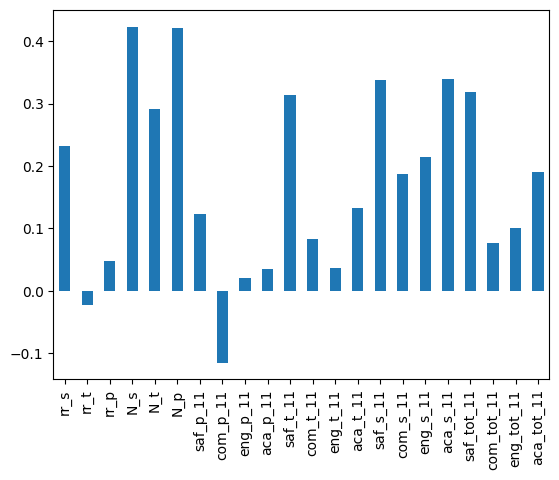

In [26]:
combined.corr(numeric_only=True)["sat_score"][survey_fields].plot.bar()

# Investigating Safety Scores

<Axes: xlabel='saf_s_11', ylabel='sat_score'>

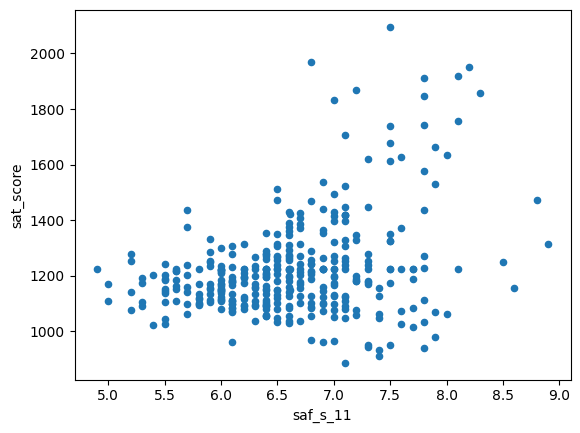

In [27]:
combined.plot.scatter(x="saf_s_11",y="sat_score")

Looks like the SAT score is more in the schools where the students feel safe.

In [36]:
combined.groupby("boro").agg('mean',numeric_only=True)["saf_s_11"]

boro
Bronx            6.606577
Brooklyn         6.370755
Manhattan        6.831370
Queens           6.721875
Staten Island    6.530000
Name: saf_s_11, dtype: float64

Average Safety Score by students are almost same across the borough. 

<Axes: >

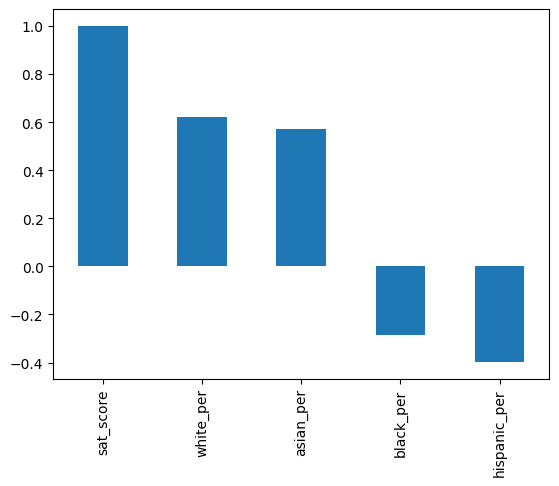

In [46]:
combined.corr(numeric_only=True)[["sat_score","white_per",
"asian_per",
"black_per",
"hispanic_per"]].loc["sat_score"].plot.bar()


White and Asian Race scores high in SAT when compared to other races.

<Axes: xlabel='hispanic_per', ylabel='sat_score'>

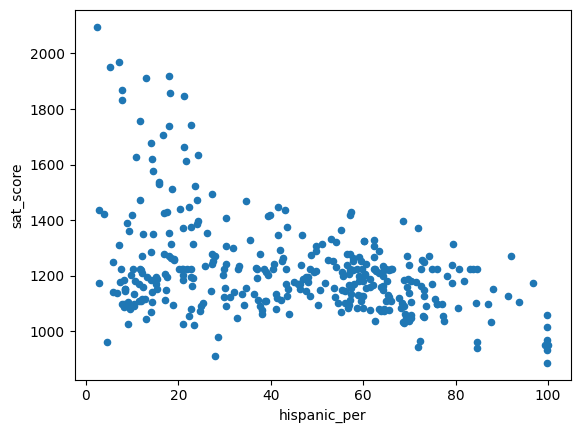

In [47]:
combined.plot.scatter(x="hispanic_per",y="sat_score")

In [49]:
combined[(combined["hispanic_per"]>40)&(combined["sat_score"]<1200)]["SCHOOL NAME"]

0          HENRY STREET SCHOOL FOR INTERNATIONAL STUDIES
1                    UNIVERSITY NEIGHBORHOOD HIGH SCHOOL
2                             EAST SIDE COMMUNITY SCHOOL
6      47 THE AMERICAN SIGN LANGUAGE AND ENGLISH SECO...
7                           FOOD AND FINANCE HIGH SCHOOL
                             ...                        
357                 ACADEMY FOR ENVIRONMENTAL LEADERSHIP
358          EBC HIGH SCHOOL FOR PUBLIC SERVICE–BUSHWICK
359                   BUSHWICK SCHOOL FOR SOCIAL JUSTICE
360                            ACADEMY OF URBAN PLANNING
362    BUSHWICK LEADERS HIGH SCHOOL FOR ACADEMIC EXCE...
Name: SCHOOL NAME, Length: 119, dtype: object

Only if the hispanic_per is less, sat score is too high in the schools.

In [50]:
combined[(combined["hispanic_per"]>95)]["SCHOOL NAME"]

44                         MANHATTAN BRIDGES HIGH SCHOOL
82      WASHINGTON HEIGHTS EXPEDITIONARY LEARNING SCHOOL
89     GREGORIO LUPERON HIGH SCHOOL FOR SCIENCE AND M...
125                  ACADEMY FOR LANGUAGE AND TECHNOLOGY
141                INTERNATIONAL SCHOOL FOR LIBERAL ARTS
176     PAN AMERICAN INTERNATIONAL HIGH SCHOOL AT MONROE
253                            MULTICULTURAL HIGH SCHOOL
286               PAN AMERICAN INTERNATIONAL HIGH SCHOOL
Name: SCHOOL NAME, dtype: object

In [51]:
combined[(combined["hispanic_per"]<10)&(combined["sat_score"]>1800)]["SCHOOL NAME"]

37                                STUYVESANT HIGH SCHOOL
151                         BRONX HIGH SCHOOL OF SCIENCE
187                       BROOKLYN TECHNICAL HIGH SCHOOL
327    QUEENS HIGH SCHOOL FOR THE SCIENCES AT YORK CO...
356                  STATEN ISLAND TECHNICAL HIGH SCHOOL
Name: SCHOOL NAME, dtype: object

<Axes: >

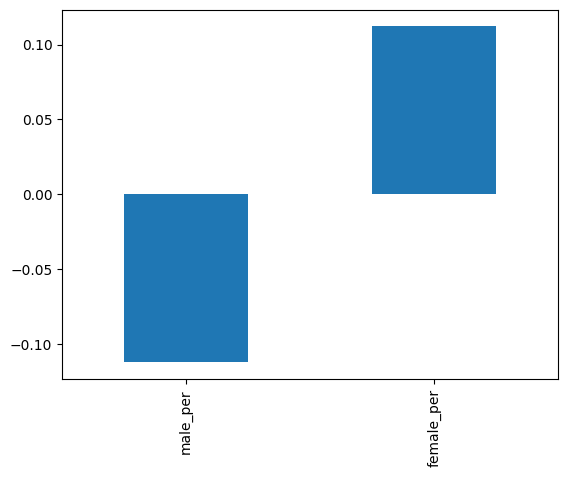

In [56]:
combined.corr(numeric_only=True)[["male_per","female_per"]].loc["sat_score"].plot.bar()

It says If the male students are more, then sat score is less, when compared to that of female students.

<Axes: xlabel='female_per', ylabel='sat_score'>

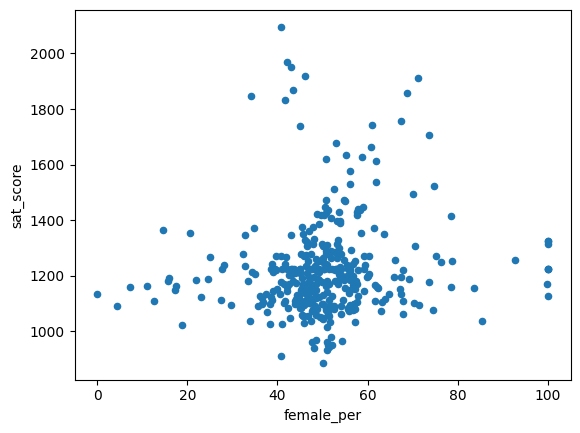

In [57]:
combined.plot.scatter(x="female_per",y="sat_score")

Most of the schools have 40 to 60% of female students, and they score good sat score. If the schools have very less females students less than 20% or more females students >80% , then sat score is going down below 1400

In [59]:
combined[(combined["female_per"]>60)&(combined["sat_score"]>1700)]["SCHOOL NAME"]

5                         BARD HIGH SCHOOL EARLY COLLEGE
26                         ELEANOR ROOSEVELT HIGH SCHOOL
60                                    BEACON HIGH SCHOOL
61     FIORELLO H. LAGUARDIA HIGH SCHOOL OF MUSIC & A...
302                          TOWNSEND HARRIS HIGH SCHOOL
Name: SCHOOL NAME, dtype: object

# Exploring AP Scores vs. SAT Scores

In [61]:
combined["ap_per"]=combined["AP Test Takers "]/combined["total_enrollment"]

<Axes: xlabel='ap_per', ylabel='sat_score'>

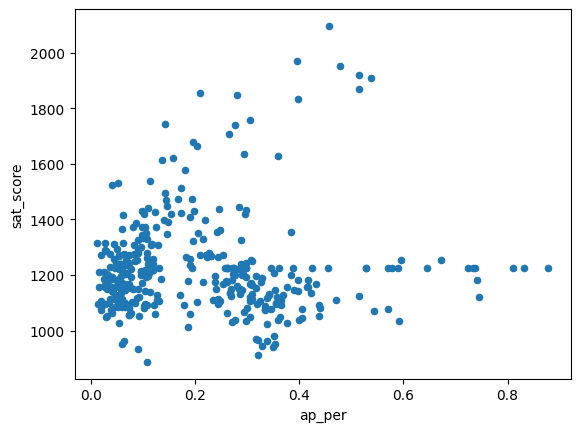

In [62]:
combined.plot.scatter(x="ap_per", y="sat_score")

If AP test takers are more than 60% of the total enrollments, then they are not taking sat exam.